<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Identificardor_de_Parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

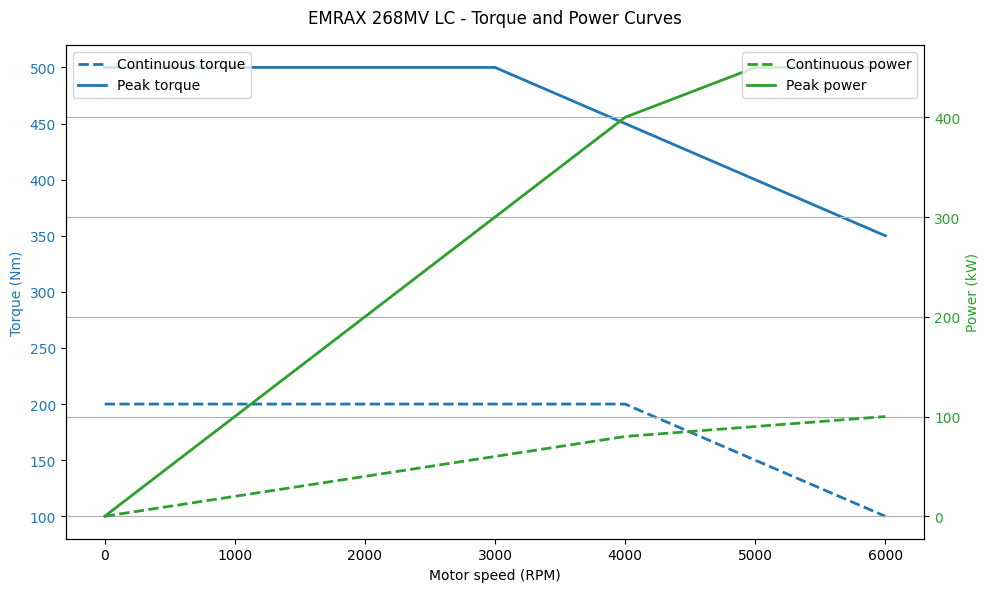

In [ ]:
# @title Estimação de curva EMRAX268
import numpy as np
import matplotlib.pyplot as plt

# Dados de RPM e Torque/Potência
rpm = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000])
torque_continuo = np.array([200, 200, 200, 200, 200, 150, 100])
torque_pico = np.array([500, 500, 500, 500, 450, 400, 350])
potencia_continua = np.array([0, 20, 40, 60, 80, 90, 100])
potencia_pico = np.array([0, 100, 200, 300, 400, 450, 450])

# Plotando as curvas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curva de Torque (em Nm)
ax1.set_xlabel('Motor speed (RPM)')
ax1.set_ylabel('Torque (Nm)', color='tab:blue')
ax1.plot(rpm, torque_continuo, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax1.plot(rpm, torque_pico, label='Peak torque', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Segundo eixo Y para Potência (em kW)
ax2 = ax1.twinx()
ax2.set_ylabel('Power (kW)', color='tab:green')
ax2.plot(rpm, potencia_continua, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(rpm, potencia_pico, label='Peak power', color='tab:green', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adicionando título e legendas
fig.suptitle('EMRAX 268MV LC - Torque and Power Curves')
fig.tight_layout()

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()


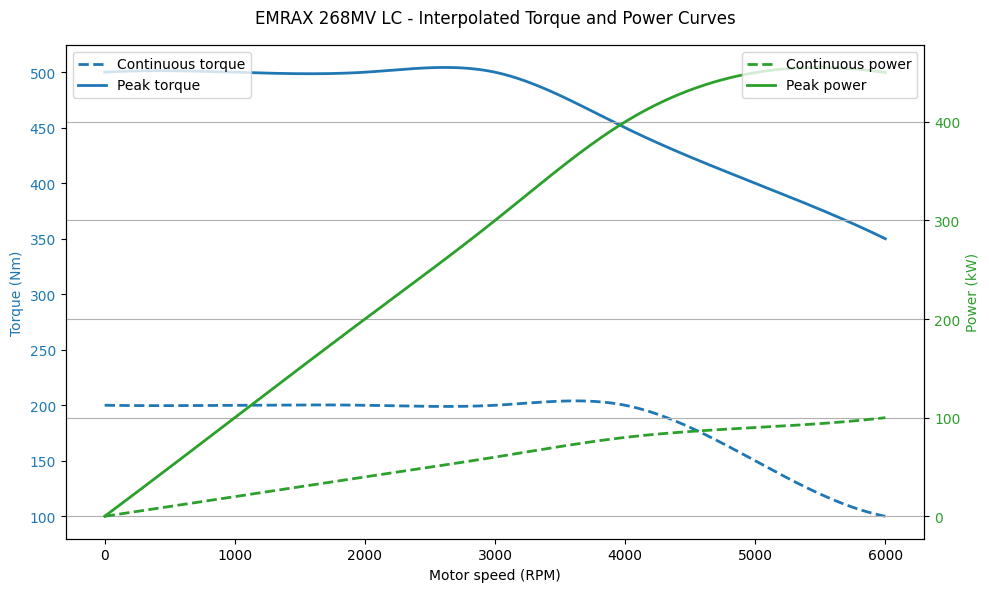

In [ ]:
# @title Splitline e Comparação EMRAX268
from scipy.interpolate import interp1d

# Interpolação para suavizar os dados
rpm_interp = np.linspace(0, 6000, 1000)  # Mais pontos de RPM para suavização
torque_continuo_interp = interp1d(rpm, torque_continuo, kind='cubic')(rpm_interp)
torque_pico_interp = interp1d(rpm, torque_pico, kind='cubic')(rpm_interp)
potencia_continua_interp = interp1d(rpm, potencia_continua, kind='cubic')(rpm_interp)
potencia_pico_interp = interp1d(rpm, potencia_pico, kind='cubic')(rpm_interp)


# Replotar com interpolação
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curva de Torque interpolada
ax1.set_xlabel('Motor speed (RPM)')
ax1.set_ylabel('Torque (Nm)', color='tab:blue')
ax1.plot(rpm_interp, torque_continuo_interp, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax1.plot(rpm_interp, torque_pico_interp, label='Peak torque', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Curva de Potência interpolada
ax2 = ax1.twinx()
ax2.set_ylabel('Power (kW)', color='tab:green')
ax2.plot(rpm_interp, potencia_continua_interp, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, potencia_pico_interp, label='Peak power', color='tab:green', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adicionando título e legendas
fig.suptitle('EMRAX 268MV LC - Interpolated Torque and Power Curves')
fig.tight_layout()

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(True)
plt.show()


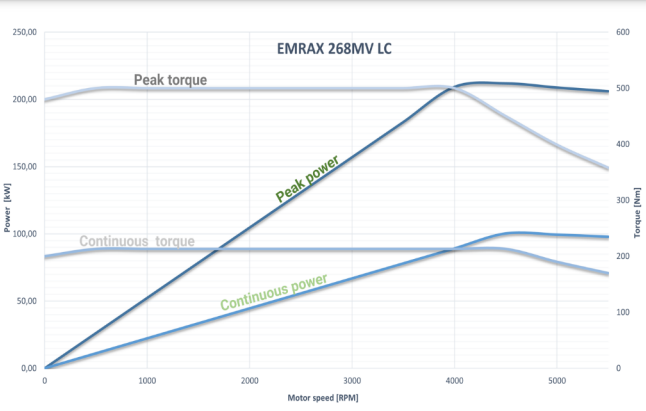

In [ ]:
import numpy as np
import plotly.graph_objects as go

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K, fe):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona
        self.fe = fe  # Frequência de entrada

    def set_frequencia(self, frequencia):
        """Atualiza a frequência e recalcula a velocidade síncrona."""
        self.frequencia = frequencia
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 ,Z1 + Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[1]
        return V_fase / Z

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[0]
        return E2

    def calcular_torque(self, V_fase, s):
       # Corrente do rotor
        E2 = self.calcular_tensao_induzida(V_fase, s)
        I2 = np.abs(E2 / (self.R2 / s + complex(0, self.X2)))
        P_r = 3 * I2**2 * (self.R2 / s)

        if self.frequencia <= self.fe:
            w_s_nominal = 2 * np.pi * self.fe / (self.P / 2)
            return self.K * P_r / w_s_nominal
        else:
            return self.K * P_r / self.w_s

    def simular_malha(self, V_fase, escorregamentos, freq_min=1, freq_max=360, passo=60):
        """Gera uma malha de torque para uma faixa de frequências e escorregamentos."""
        frequencias = np.arange(freq_min, freq_max + 1, passo)
        escorregamentos = np.array(escorregamentos)
        torques = np.zeros((len(frequencias), len(escorregamentos)))

        for i, freq in enumerate(frequencias):
            self.set_frequencia(freq)
            torques[i, :] = [self.calcular_torque(V_fase, s) for s in escorregamentos]

        return frequencias, escorregamentos, torques

    def plotar_superficie_torque(self, V_fase, escorregamentos,Polos, freq_min=12, freq_max=120, passo=12):
        """Plota o gráfico de superfície interativo usando Plotly, com RPM e linhas para torque nominal e máximo."""
        # Simular a malha de torques
        frequencias, escorreg, torques = self.simular_malha(V_fase, escorregamentos, freq_min, freq_max, passo)

        # Converter frequências para RPM
        rpm = (120 * frequencias) / Polos  # Fórmula para RPM


        s_nominal = 0.03
        # Determinar o torque nominal (s = 0.07)
        idx_nominal = np.where(np.isclose(escorreg, s_nominal, atol=0.0001))[0]
        if len(idx_nominal) > 0:
            torque_nominal = torques[:, idx_nominal[0]]  # Coluna associada ao escorregamento nominal
        else:
            torque_nominal = None
            print(f"Escorregamento nominal ({s_nominal}) não encontrado na lista de escorregamentos.")


        # Determinar o torque máximo
        torques_maximos = [max(torques[i]) for i in range(len(frequencias))]
        s_maximos = [escorreg[torques[i].argmax()] for i in range(len(frequencias))]  # Escorregamento associado ao torque máximo

        # Calcular a potência para o torque nominal e máximo
        pn = [torque_nominal[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]
        pmax = [torques_maximos[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]  # Potência máxima


        # Criar o gráfico 3D
        fig = go.Figure()

        # Superfície 3D
        fig.add_trace(go.Surface(
            x=escorreg,  # Escorregamento no eixo X
            y=rpm,  # RPM no eixo Y
            z=torques,  # Torque no eixo Z
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Torque (Nm)")
        ))

        # Adicionar linha para torque nominal (se encontrada)
        if torque_nominal is not None:
            fig.add_trace(go.Scatter3d(
                x=[s_nominal] * len(frequencias),  # Escorregamento fixo
                y=rpm,  # RPM
                z=torque_nominal,  # Torque nominal
                mode='lines',
                line=dict(color='red', width=4),
                name=f"Nominal Torque ({s_nominal})",
            ))


        # Adicionar linha para torque máximo
        fig.add_trace(go.Scatter3d(
            x=s_maximos,  # Escorregamentos associados ao torque máximo
            y=rpm,  # RPM
            z=torques_maximos,  # Torque máximo
            mode='lines',
            line=dict(color='blue', width=4),
            name="Max Torque"
        ))

        # Configurações do layout

        fig.update_layout(
            title="Torque vs Slip vs RPM Surface",
            scene=dict(
                xaxis_title="Slip",
                yaxis_title="RPM",
                zaxis_title="Torque (Nm)",
                yaxis=dict(autorange="reversed")  # Invertendo o eixo de frequência
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40),width=800, height=600
        )

        fig.show()

        # Criando o gráfico de potência com duas escalas
        fig1 = go.Figure()

        # Potência nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pn,
            mode='lines',
            line=dict(color='red', width=4),
            name=f"Nominal Power (Pn)"
        ))

        # Potência máxima
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pmax,
            mode='lines',
            line=dict(color='red', width=4, dash='dash'),
            name=f"Max Power"
        ))
        #torque nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torque_nominal,
            mode='lines',
            line=dict(color='blue', width=4),
            name=f"Nominal Torque ",
            yaxis='y2'
        ))
        #torque máximo
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torques_maximos,
            mode='lines',
            line=dict(color='blue', width=4, dash='dash'),
            name=f"Max Torque",
            yaxis='y2'
        ))

        # Adicionando a segunda escala (para o torque)
        fig1.update_layout(
            title="Power vs Torque",
            xaxis=dict(
                title="RPM",
                showgrid=False
            ),
            yaxis=dict(
                title="Power (kW)",
                titlefont=dict(color='red'),
                tickfont=dict(color='red'),
                side='left'
            ),
            yaxis2=dict(
                title="Torque (Nm)",
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue'),
                overlaying='y',
                side='right'
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40),width=800, height=600
        )

        fig1.show()
        return torque_nominal, torque_max, pn ,pmax






# Parâmetros iniciais do motor
frequencia = 60  # Frequência inicial em Hz
P = 4  # Número de polos
R1 = 0.2 # Resistência do estator
X1 = 3   # Reatância do estator
R2 = 1.3 # Resistência do rotor
X2 = 2  # Reatância do rotor
Xm = 28  # Reatância magnética
K = 1  # Constante de proporcionalidade
fe= 60


motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K,fe)

# Simulação
V_fase = 220 / np.sqrt(3)  # Tensão de fase
escorregamentos = np.linspace(0.001, 1, 10000)  # Escorregamento de 1% a 100%

motor.plotar_superficie_torque(V_fase, escorregamentos,P, freq_min=0.12, freq_max=120, passo=12)
torquesimulado = motor.plotar_superficie_torque(V_fase, escorregamentos,P, freq_min=0.12, freq_max=120, passo=12)[0]

Parâmetros otimizados: [1.04811368e+00 1.00000000e-02 5.15359532e-01 1.00000000e-02
 3.00000000e+02]


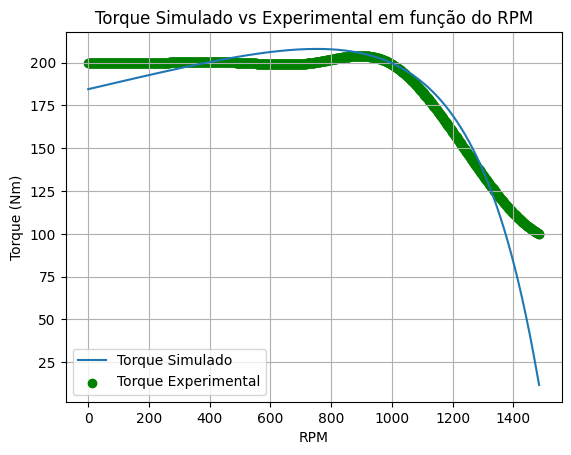

In [ ]:
# @title Identificação e análise de parâmetros
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.N_s = 120 * self.frequencia / self.P  # Velocidade síncrona em RPM

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1

    def calcular_torque(self, V_fase, s):
        E2 = self.calcular_tensao_induzida(V_fase, s)
        I2 = self.calcular_corrente_de_armadura(V_fase, s)
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / (2 * np.pi * self.N_s / 60)  # Convertendo velocidade síncrona de RPM para rad/s
        return self.K * torque

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_armadura(self, V_fase, s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_erro(self, params, V_fase, s, torque_experimental):
        self.R1, self.X1, self.R2, self.X2, self.Xm = params
        torque_simulado = self.calcular_torque(V_fase, s)
        erro_total = np.sum((torque_simulado - torque_experimental) ** 2)
        return erro_total

# Função de erro total
def total_error(params, motor, V_fase, escorregamento, torque_experimental):
    return motor.calcular_erro(params, V_fase, escorregamento, torque_experimental)

# Dados experimentais de torque para escorregamento
escorregamentos = np.linspace(0.01, 1, 1000)  # Escorregamentos simulados
torques_experimentais = torque_continuo_interp  # Dados de torque (substitua pelos dados reais)

torques_experimentais_invertidos = torques_experimentais[::-1]

# Instanciando o motor com valores iniciais
motor = MotorDeGaiola(frequencia=50, P=4, R1=0.1, X1=0.2, R2=0.1, X2=0.2, Xm=5, K=0.95)

# Parâmetros a serem otimizados: [R1, X1, R2, X2, Xm]
parametros_iniciais = [0.1, 0.2, 0.1, 0.2, 5]
param_bounds = [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 10), (0.1, 300)]

# Função de otimização
result = opt.minimize(total_error, parametros_iniciais, args=(motor, 220, escorregamentos, torques_experimentais_invertidos), bounds=param_bounds)

# Imprimindo parâmetros otimizados
parametros_otimizados = result.x
print(f"Parâmetros otimizados: {parametros_otimizados}")

# Comparando torque simulado com experimental
torques_simulados = [motor.calcular_torque(220, s) for s in escorregamentos]

# Convertendo escorregamento para RPM
rpm_simulados = motor.N_s * (1 - escorregamentos)

plt.plot(rpm_simulados, torques_simulados, label='Torque Simulado')
#plt.scatter(rpm_simulados, torques_experimentais, color='red', label='Torque Experimental')
plt.scatter(rpm_simulados, torques_experimentais_invertidos, color='green', label='Torque Experimental')
plt.xlabel('RPM')
plt.ylabel('Torque (Nm)')
plt.title('Torque Simulado vs Experimental em função do RPM')
plt.legend()
plt.grid(True)
plt.show()
